In [1]:
# %%
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Tuning & Metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

print("✅ Libraries imported.")

✅ Libraries imported.


In [2]:
import sklearn
print(sklearn.__version__)


1.7.2


In [3]:
# %%
data_path = '../data/processed_diabetes_data.pkl'

if os.path.exists(data_path):
    data = joblib.load(data_path)
    
    # Extract the arrays
    X_train = data['X_train']
    y_train = data['y_train']
    # We load validation data just to check shape, but we tune using CV on X_train
    X_val = data['X_val']
    y_val = data['y_val']
    
    print(f"✅ Data Loaded Successfully!")
    print(f"   Training Samples (Balanced): {X_train.shape[0]}")
    print(f"   Validation Samples: {X_val.shape[0]}")
else:
    print("❌ Error: 'processed_diabetes_data.pkl' not found.")
    print("   Please ask Member 3 to run the export code at the end of their notebook.")

✅ Data Loaded Successfully!
   Training Samples (Balanced): 700
   Validation Samples: 115


In [4]:
# %%
model_configs = {
    'Logistic_Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'solver': ['liblinear']
        }
    },
    'SVM': {
        'model': SVC(probability=True, random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear']
        }
    },
    'Random_Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_leaf': [1, 2]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(eval_metric='logloss', random_state=42, use_label_encoder=False),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 6]
        }
    }
}
print("✅ Models and parameters defined.")

✅ Models and parameters defined.


In [5]:
# %%
best_estimators = {}
tuning_results = []

print("🚀 Starting Hyperparameter Tuning (this may take 1-2 minutes)...")

for name, config in model_configs.items():
    print(f"🔹 Tuning {name}...")
    
    # Grid Search optimizing for F1-Score (crucial for imbalanced medical data)
    grid = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=5,
        scoring='f1',
        n_jobs=-1
    )
    
    # Train on the balanced training set
    grid.fit(X_train, y_train)
    
    # Save the best model and score
    best_estimators[name] = grid.best_estimator_
    tuning_results.append({
        'Model': name,
        'Best_CV_F1': grid.best_score_,
        'Best_Params': grid.best_params_
    })
    
    print(f"   ✅ Best F1 Score: {grid.best_score_:.4f}")

print("\n🏁 Tuning Complete!")

🚀 Starting Hyperparameter Tuning (this may take 1-2 minutes)...
🔹 Tuning Logistic_Regression...
   ✅ Best F1 Score: 0.7524
🔹 Tuning SVM...
   ✅ Best F1 Score: 0.8161
🔹 Tuning Random_Forest...
   ✅ Best F1 Score: 0.8348
🔹 Tuning XGBoost...
   ✅ Best F1 Score: 0.8187

🏁 Tuning Complete!


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning: [18:00:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🏆 Model Leaderboard:
                 Model  Best_CV_F1  \
2        Random_Forest    0.834760   
3              XGBoost    0.818710   
1                  SVM    0.816085   
0  Logistic_Regression    0.752408   

                                         Best_Params  
2  {'max_depth': 10, 'min_samples_leaf': 1, 'n_es...  
3  {'learning_rate': 0.1, 'max_depth': 6, 'n_esti...  
1                         {'C': 10, 'kernel': 'rbf'}  
0                    {'C': 1, 'solver': 'liblinear'}  


C:\Users\hp\AppData\Local\Temp\ipykernel_14340\1554859135.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Best_CV_F1', y='Model', data=results_df, palette='viridis')


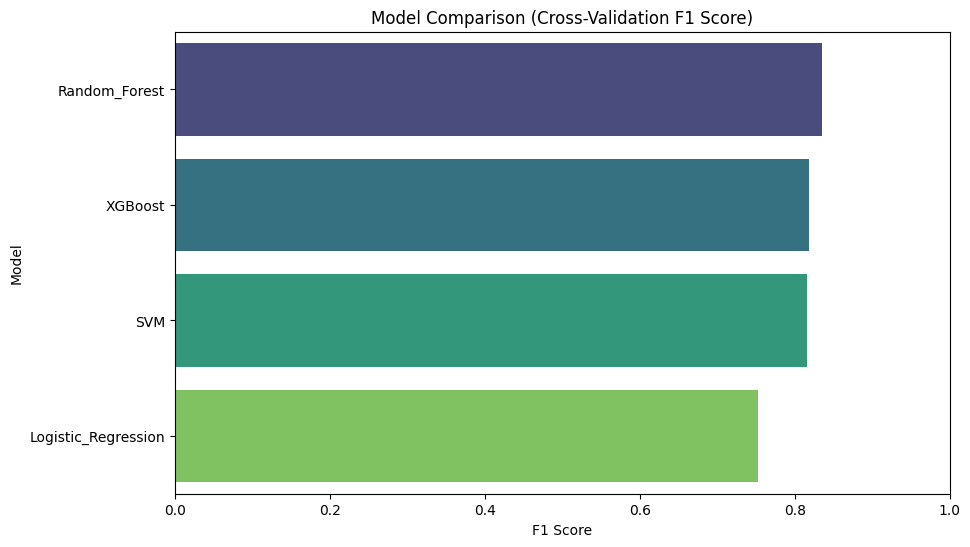

In [6]:
# %%
# Create a DataFrame for easy viewing
results_df = pd.DataFrame(tuning_results).sort_values(by='Best_CV_F1', ascending=False)

print("\n🏆 Model Leaderboard:")
print(results_df[['Model', 'Best_CV_F1', 'Best_Params']])

# Plotting the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Best_CV_F1', y='Model', data=results_df, palette='viridis')
plt.title('Model Comparison (Cross-Validation F1 Score)')
plt.xlabel('F1 Score')
plt.xlim(0, 1.0)
plt.show()

In [7]:
# %%
# Create the directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

print("💾 Saving final models...")

for name, model in best_estimators.items():
    filename = f"../models/{name.lower()}_model.pkl"
    joblib.dump(model, filename)
    print(f"   -> Saved: {filename}")

print("\n✨ Success! All models are saved and ready for evaluation.")

💾 Saving final models...
   -> Saved: ../models/logistic_regression_model.pkl
   -> Saved: ../models/svm_model.pkl
   -> Saved: ../models/random_forest_model.pkl
   -> Saved: ../models/xgboost_model.pkl

✨ Success! All models are saved and ready for evaluation.
